In [95]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime
from datetime import timedelta
import seaborn as sns
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [94]:
df_chicago = pd.read_csv('../dataset/chicago_2018_clean.csv')
df_weather = pd.read_csv('../dataset/chicago_weather_2018.csv')

# Disclaimer: When we later on talk about demand, we always mean the hourly demand
# Also the column 'Demand' which will be added later on, is representing the hourly demand

In [95]:
df_sorted = df_chicago.sort_values(by=['start_time'], ascending = [True])
df_sorted.head(9)

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,duration_per_trip,trip_time_in_hours
3212538,2018-01-01 00:12:00,2018-01-01 00:17:23,69,159,Damen Ave & Pierce Ave,Claremont Ave & Hirsch St,3304,Subscriber,0 days 00:05:23,0.089722
3212539,2018-01-01 00:41:35,2018-01-01 00:47:52,253,325,Winthrop Ave & Lawrence Ave,Clark St & Winnemac Ave (Temp),5367,Subscriber,0 days 00:06:17,0.104722
3212540,2018-01-01 00:44:46,2018-01-01 01:33:10,98,509,LaSalle St & Washington St,Troy St & North Ave,4599,Subscriber,0 days 00:48:24,0.806667
3212541,2018-01-01 00:53:10,2018-01-01 01:05:37,125,364,Rush St & Hubbard St,Larrabee St & Oak St,2302,Subscriber,0 days 00:12:27,0.207500
3212542,2018-01-01 00:53:37,2018-01-01 00:56:40,129,205,Blue Island Ave & 18th St,Paulina St & 18th St,3696,Subscriber,0 days 00:03:03,0.050833
3212543,2018-01-01 00:56:15,2018-01-01 01:00:41,304,299,Broadway & Waveland Ave,Halsted St & Roscoe St,6298,Subscriber,0 days 00:04:26,0.073889
3212544,2018-01-01 00:57:26,2018-01-01 01:02:40,164,174,Franklin St & Lake St,Canal St & Madison St,1169,Subscriber,0 days 00:05:14,0.087222
3212545,2018-01-01 01:00:29,2018-01-01 01:13:43,182,142,Wells St & Elm St,McClurg Ct & Erie St,6351,Subscriber,0 days 00:13:14,0.220556
3212546,2018-01-01 01:07:12,2018-01-01 01:31:53,99,99,Lake Shore Dr & Ohio St,Lake Shore Dr & Ohio St,1920,Customer,0 days 00:24:41,0.411389


In [96]:
#rename date_time column of df_weather in order to successfully merge system load and weather dataframe later on
df_weather.rename(columns = {'date_time':'start_time'}, inplace = True)
#convert now start_time column to datetime format in order to merge later on
df_weather['start_time'] = pd.to_datetime(df_weather['start_time']) #TODO: wetter datei nochmal neu holen
df_weather.head(20)

,start_time,max_temp,min_temp,precip
0,2018-01-01 00:00:00,-13.9,-13.9,0.0
1,2018-01-01 01:00:00,-15.0,-15.0,0.0
2,2018-01-01 02:00:00,-15.6,-15.6,0.0
3,2018-01-01 03:00:00,-16.7,-16.7,0.0
4,2018-01-01 04:00:00,-17.2,-17.2,0.0
5,2018-01-01 05:00:00,-17.8,-17.8,0.0
6,2018-01-01 06:00:00,-18.3,-18.3,0.0
7,2018-01-01 07:00:00,-19.4,-19.4,0.0
8,2018-01-01 08:00:00,-20.0,-20.0,0.0
9,2018-01-01 09:00:00,-20.6,-20.6,0.0


In [97]:
#we calculate the hourly system demand by summing up the number of biketrips started in one hour
df_sorted['start_time'] = pd.to_datetime(df_sorted['start_time'])
df_sorted['end_time'] = pd.to_datetime(df_sorted['end_time'])
df_load = df_sorted.groupby([pd.Grouper(key='start_time',freq='H')]).size().reset_index(name='Demand')
df_load

,start_time,Demand
0,2018-01-01 00:00:00,7
1,2018-01-01 01:00:00,14
2,2018-01-01 02:00:00,10
3,2018-01-01 03:00:00,2
4,2018-01-01 04:00:00,2
...,...,...
8755,2018-12-31 19:00:00,41
8756,2018-12-31 20:00:00,28
8757,2018-12-31 21:00:00,22
8758,2018-12-31 22:00:00,25


In [98]:
# merge Demand dataframe with weather dataframe
# calculate average temperature within the hour to check correlation with demand later on

df_load_weather = pd.merge(df_load, df_weather, on='start_time')
#calculate average ter
df_load_weather['avg_temp'] = (df_load_weather['max_temp'] + df_load_weather['min_temp'])/2
#since we only inspect the average temperature in the hour, we can drop the max_temp and min_temp columns
df_load_weather.head(10)

,start_time,Demand,max_temp,min_temp,precip,avg_temp
0,2018-01-01 00:00:00,7,-13.9,-13.9,0.0,-13.9
1,2018-01-01 01:00:00,14,-15.0,-15.0,0.0,-15.0
2,2018-01-01 02:00:00,10,-15.6,-15.6,0.0,-15.6
3,2018-01-01 03:00:00,2,-16.7,-16.7,0.0,-16.7
4,2018-01-01 04:00:00,2,-17.2,-17.2,0.0,-17.2
5,2018-01-01 05:00:00,3,-17.8,-17.8,0.0,-17.8
6,2018-01-01 06:00:00,5,-18.3,-18.3,0.0,-18.3
7,2018-01-01 07:00:00,5,-19.4,-19.4,0.0,-19.4
8,2018-01-01 08:00:00,7,-20.0,-20.0,0.0,-20.0
9,2018-01-01 09:00:00,10,-20.6,-20.6,0.0,-20.6


In [99]:
df_load_weather.drop(['max_temp', 'min_temp'], axis = 1, inplace = True)
df_load_weather.head(10)

,start_time,Demand,precip,avg_temp
0,2018-01-01 00:00:00,7,0.0,-13.9
1,2018-01-01 01:00:00,14,0.0,-15.0
2,2018-01-01 02:00:00,10,0.0,-15.6
3,2018-01-01 03:00:00,2,0.0,-16.7
4,2018-01-01 04:00:00,2,0.0,-17.2
5,2018-01-01 05:00:00,3,0.0,-17.8
6,2018-01-01 06:00:00,5,0.0,-18.3
7,2018-01-01 07:00:00,5,0.0,-19.4
8,2018-01-01 08:00:00,7,0.0,-20.0
9,2018-01-01 09:00:00,10,0.0,-20.6


In [100]:
# create new column for only the hour of the starttime
# since calculating the correlation between a int object (Demand) and a datetime (start_time) object is tricky, 
# we save the hour of the starting time in a new column to make this operation easier

df_load_weather['start_hour'] = df_load_weather['start_time'].dt.hour

In [101]:
# Handeling cyclical data
# Since our algorithms later wont know that the hour 0 comes directly after the hour 23, we need to transform our
# time data in such a way that no important information is lost due to the unfitting representation of time
# We will use sinus and cosinus functions to connect the end of the day with the beginning of the next one

df_load_weather['sin_hour'] = np.sin(2*np.pi*df_load_weather['start_hour']/24)
df_load_weather['cos_hour'] = np.cos(2*np.pi*df_load_weather['start_hour']/24)
df_load_weather.head(25)

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000e+00,1.000000e+00
1,2018-01-01 01:00:00,14,0.0,-15.0,1,2.588190e-01,9.659258e-01
2,2018-01-01 02:00:00,10,0.0,-15.6,2,5.000000e-01,8.660254e-01
3,2018-01-01 03:00:00,2,0.0,-16.7,3,7.071068e-01,7.071068e-01
4,2018-01-01 04:00:00,2,0.0,-17.2,4,8.660254e-01,5.000000e-01
5,2018-01-01 05:00:00,3,0.0,-17.8,5,9.659258e-01,2.588190e-01
6,2018-01-01 06:00:00,5,0.0,-18.3,6,1.000000e+00,6.123234e-17
7,2018-01-01 07:00:00,5,0.0,-19.4,7,9.659258e-01,-2.588190e-01
8,2018-01-01 08:00:00,7,0.0,-20.0,8,8.660254e-01,-5.000000e-01
9,2018-01-01 09:00:00,10,0.0,-20.6,9,7.071068e-01,-7.071068e-01


In [102]:
# create new column for start_month
# same as for start_hour: we want to check the correlation between the month the trips are in and the demand
df_load_weather['start_month'] = df_load_weather['start_time'].dt.month

# The start month is also a cyclical feature, which is why we need also need to transform it
df_load_weather['sin_month'] = np.sin(2*np.pi*(df_load_weather['start_month'])/12)
df_load_weather['cos_month'] = np.cos(2*np.pi*df_load_weather['start_month']/12)

df_load_weather

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month
0,2018-01-01 00:00:00,7,0.0,-13.90,0,0.000000,1.000000,1,5.000000e-01,0.866025
1,2018-01-01 01:00:00,14,0.0,-15.00,1,0.258819,0.965926,1,5.000000e-01,0.866025
2,2018-01-01 02:00:00,10,0.0,-15.60,2,0.500000,0.866025,1,5.000000e-01,0.866025
3,2018-01-01 03:00:00,2,0.0,-16.70,3,0.707107,0.707107,1,5.000000e-01,0.866025
4,2018-01-01 04:00:00,2,0.0,-17.20,4,0.866025,0.500000,1,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...
8755,2018-12-31 19:00:00,41,1.0,3.30,19,-0.965926,0.258819,12,-2.449294e-16,1.000000
8756,2018-12-31 20:00:00,28,1.0,3.60,20,-0.866025,0.500000,12,-2.449294e-16,1.000000
8757,2018-12-31 21:00:00,22,1.0,3.45,21,-0.707107,0.707107,12,-2.449294e-16,1.000000
8758,2018-12-31 22:00:00,25,0.0,3.30,22,-0.500000,0.866025,12,-2.449294e-16,1.000000


In [103]:
# holiday check
# following days where federal holidays in Illinois (the state chicago is located in):
# 01.01, 15.01, 12.02, 19.02, 05.03, 28.05, 04.07, 03.09, 08.10, 06.11, 12.11, 22.11, 23.11, 05.12, 24.12, 25.12
# source: TODO noch hinzufügen

holidays = np.array([
    datetime.date(2018,1,1),
    datetime.date(2018,1,15),
    datetime.date(2018,2,12),
    datetime.date(2018,2,19),
    datetime.date(2018,3,5),
    datetime.date(2018,5,28),
    datetime.date(2018,7,4),
    datetime.date(2018,9,3),
    datetime.date(2018,10,8),
    datetime.date(2018,11,6),
    datetime.date(2018,11,12),
    datetime.date(2018,11,22),
    datetime.date(2018,11,23),
    datetime.date(2018,12,5),
    datetime.date(2018,12,24),
    datetime.date(2018,12,25),
])
print(holidays)

#conditions = [df_load_weather['star_time'].date()= ]

[datetime.date(2018, 1, 1) datetime.date(2018, 1, 15)
 datetime.date(2018, 2, 12) datetime.date(2018, 2, 19)
 datetime.date(2018, 3, 5) datetime.date(2018, 5, 28)
 datetime.date(2018, 7, 4) datetime.date(2018, 9, 3)
 datetime.date(2018, 10, 8) datetime.date(2018, 11, 6)
 datetime.date(2018, 11, 12) datetime.date(2018, 11, 22)
 datetime.date(2018, 11, 23) datetime.date(2018, 12, 5)
 datetime.date(2018, 12, 24) datetime.date(2018, 12, 25)]


In [104]:
#create new column in df_load_weather to signal if day was a holiday
#Holiday column is important so we can later check, if there is a correlation between holidays and Demand
df_load_weather['start_time'] = pd.to_datetime(df_load_weather['start_time'])
df_load_weather['isHoliday'] = df_load_weather['start_time'].dt.date.isin(holidays)

# since we want to make sure that the correlation is calculated properly, we transform the currently boolean values
# of isHoliday to int values: 1 = this date was a holiday; 2 = this date wasn't a holiday
df_load_weather['isHoliday'] = df_load_weather['isHoliday'].astype(int)

df_load_weather.head(10)

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,isHoliday
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000,1.000000e+00,1,0.5,0.866025,1
1,2018-01-01 01:00:00,14,0.0,-15.0,1,0.258819,9.659258e-01,1,0.5,0.866025,1
2,2018-01-01 02:00:00,10,0.0,-15.6,2,0.500000,8.660254e-01,1,0.5,0.866025,1
3,2018-01-01 03:00:00,2,0.0,-16.7,3,0.707107,7.071068e-01,1,0.5,0.866025,1
4,2018-01-01 04:00:00,2,0.0,-17.2,4,0.866025,5.000000e-01,1,0.5,0.866025,1
5,2018-01-01 05:00:00,3,0.0,-17.8,5,0.965926,2.588190e-01,1,0.5,0.866025,1
6,2018-01-01 06:00:00,5,0.0,-18.3,6,1.000000,6.123234e-17,1,0.5,0.866025,1
7,2018-01-01 07:00:00,5,0.0,-19.4,7,0.965926,-2.588190e-01,1,0.5,0.866025,1
8,2018-01-01 08:00:00,7,0.0,-20.0,8,0.866025,-5.000000e-01,1,0.5,0.866025,1
9,2018-01-01 09:00:00,10,0.0,-20.6,9,0.707107,-7.071068e-01,1,0.5,0.866025,1


In [105]:
# Create new column 'day_of_Week' in df_load_weather to determine, which weekday/weekend-day it was at this date
# Crate dummy-variables to symbolize differnt days of the week
# Explain Indizes: 1=Monday, 2=Tuesday, 3=Wednesday, 4=Thursday, 5=Friday, 6=Saturday, 7=Sunday
# Will be used later to check correlation between weekdays and system demand

df_load_weather['day_of_Week'] = df_load_weather['start_time'].dt.isocalendar().day

# Since day_of_Week is once again a cyclical feature, we again need to transform it in order to have continous data
# instead of interrupt changes when the new week begins

df_load_weather['sin_day_of_Week'] = np.sin(2*np.pi*df_load_weather['day_of_Week']/7)
df_load_weather['cos_day_of_Week'] = np.cos(2*np.pi*df_load_weather['day_of_Week']/7)
df_load_weather.head(500)


,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,isHoliday,day_of_Week,sin_day_of_Week,cos_day_of_Week
0,2018-01-01 00:00:00,7,0.0,-13.90,0,0.000000,1.000000e+00,1,0.5,0.866025,1,1,0.781831,0.62349
1,2018-01-01 01:00:00,14,0.0,-15.00,1,0.258819,9.659258e-01,1,0.5,0.866025,1,1,0.781831,0.62349
2,2018-01-01 02:00:00,10,0.0,-15.60,2,0.500000,8.660254e-01,1,0.5,0.866025,1,1,0.781831,0.62349
3,2018-01-01 03:00:00,2,0.0,-16.70,3,0.707107,7.071068e-01,1,0.5,0.866025,1,1,0.781831,0.62349
4,2018-01-01 04:00:00,2,0.0,-17.20,4,0.866025,5.000000e-01,1,0.5,0.866025,1,1,0.781831,0.62349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2018-01-21 15:00:00,222,0.0,4.40,15,-0.707107,-7.071068e-01,1,0.5,0.866025,0,7,-0.0,1.0
496,2018-01-21 16:00:00,182,0.0,4.70,16,-0.866025,-5.000000e-01,1,0.5,0.866025,0,7,-0.0,1.0
497,2018-01-21 17:00:00,167,0.0,5.00,17,-0.965926,-2.588190e-01,1,0.5,0.866025,0,7,-0.0,1.0
498,2018-01-21 18:00:00,140,0.0,6.40,18,-1.000000,-1.836970e-16,1,0.5,0.866025,0,7,-0.0,1.0


In [106]:
# Create new column: season
# We later want to check the correlation between the season and the demand
# Create Dummy-Variables to symbolize different seasons
# Indizes Explanation: 1: Winter {Dec, Jan, Feb}; 2: Spring {Mar, April, May}; 3: Summer {June, July, Aug}; 4: Autumn {Sep, Oct, Nov}
# Seasons are technically also a cyclical feature, but since we only look at one year in our dataset, season don't
# occur more than once, hence no need for transforming the data
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]

monthToSeason = dict(zip(range(1,13), seasons))

df_load_weather['season'] = df_load_weather['start_time'].dt.month.map(monthToSeason)
df_load_weather.head(7000)

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,isHoliday,day_of_Week,sin_day_of_Week,cos_day_of_Week,season
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000e+00,1.000000,1,0.500000,0.866025,1,1,0.781831,0.62349,1
1,2018-01-01 01:00:00,14,0.0,-15.0,1,2.588190e-01,0.965926,1,0.500000,0.866025,1,1,0.781831,0.62349,1
2,2018-01-01 02:00:00,10,0.0,-15.6,2,5.000000e-01,0.866025,1,0.500000,0.866025,1,1,0.781831,0.62349,1
3,2018-01-01 03:00:00,2,0.0,-16.7,3,7.071068e-01,0.707107,1,0.500000,0.866025,1,1,0.781831,0.62349,1
4,2018-01-01 04:00:00,2,0.0,-17.2,4,8.660254e-01,0.500000,1,0.500000,0.866025,1,1,0.781831,0.62349,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,2018-10-19 11:00:00,327,0.0,7.8,11,2.588190e-01,-0.965926,10,-0.866025,0.500000,0,5,-0.974928,-0.222521,4
6996,2018-10-19 12:00:00,314,0.0,8.3,12,1.224647e-16,-1.000000,10,-0.866025,0.500000,0,5,-0.974928,-0.222521,4
6997,2018-10-19 13:00:00,282,0.0,8.9,13,-2.588190e-01,-0.965926,10,-0.866025,0.500000,0,5,-0.974928,-0.222521,4
6998,2018-10-19 14:00:00,302,0.0,9.4,14,-5.000000e-01,-0.866025,10,-0.866025,0.500000,0,5,-0.974928,-0.222521,4


In [107]:
# Create new column for possible feature: rush_Hour
# We will check later, if a correlatio between datasets in the rush_Hour and the Demand exists
# Rushhour in chicago is between (06:00am and 08:00) am and (04:00pm and 06:00pm)


df_load_weather['in_rush_Hour'] = False
df_load_weather['in_rush_Hour'] = np.where((df_load_weather['start_time'].dt.time.ge(datetime.time(6,0,0)) & df_load_weather['start_time'].dt.time.le(datetime.time(8,0,0)))
                                              | (df_load_weather['start_time'].dt.time.ge(datetime.time(16,0,0)) & df_load_weather['start_time'].dt.time.le(datetime.time(18,0,0))),1,0
                                          
                                          )



In [108]:
df_load_weather.head(25)

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,isHoliday,day_of_Week,sin_day_of_Week,cos_day_of_Week,season,in_rush_Hour
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000e+00,1.000000e+00,1,0.5,0.866025,1,1,0.781831,0.62349,1,0
1,2018-01-01 01:00:00,14,0.0,-15.0,1,2.588190e-01,9.659258e-01,1,0.5,0.866025,1,1,0.781831,0.62349,1,0
2,2018-01-01 02:00:00,10,0.0,-15.6,2,5.000000e-01,8.660254e-01,1,0.5,0.866025,1,1,0.781831,0.62349,1,0
3,2018-01-01 03:00:00,2,0.0,-16.7,3,7.071068e-01,7.071068e-01,1,0.5,0.866025,1,1,0.781831,0.62349,1,0
4,2018-01-01 04:00:00,2,0.0,-17.2,4,8.660254e-01,5.000000e-01,1,0.5,0.866025,1,1,0.781831,0.62349,1,0
5,2018-01-01 05:00:00,3,0.0,-17.8,5,9.659258e-01,2.588190e-01,1,0.5,0.866025,1,1,0.781831,0.62349,1,0
6,2018-01-01 06:00:00,5,0.0,-18.3,6,1.000000e+00,6.123234e-17,1,0.5,0.866025,1,1,0.781831,0.62349,1,1
7,2018-01-01 07:00:00,5,0.0,-19.4,7,9.659258e-01,-2.588190e-01,1,0.5,0.866025,1,1,0.781831,0.62349,1,1
8,2018-01-01 08:00:00,7,0.0,-20.0,8,8.660254e-01,-5.000000e-01,1,0.5,0.866025,1,1,0.781831,0.62349,1,1
9,2018-01-01 09:00:00,10,0.0,-20.6,9,7.071068e-01,-7.071068e-01,1,0.5,0.866025,1,1,0.781831,0.62349,1,0


In [109]:
#Create new column prev_Demand to later check if there is a correlation between the demand of the previous hour and the current one

df_load_weather['prev_Demand'] = df_load_weather['Demand'].shift()
df_load_weather.head(10)


,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,isHoliday,day_of_Week,sin_day_of_Week,cos_day_of_Week,season,in_rush_Hour,prev_Demand
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000,1.000000e+00,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,NaN
1,2018-01-01 01:00:00,14,0.0,-15.0,1,0.258819,9.659258e-01,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,7.0
2,2018-01-01 02:00:00,10,0.0,-15.6,2,0.500000,8.660254e-01,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,14.0
3,2018-01-01 03:00:00,2,0.0,-16.7,3,0.707107,7.071068e-01,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,10.0
4,2018-01-01 04:00:00,2,0.0,-17.2,4,0.866025,5.000000e-01,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,2.0
5,2018-01-01 05:00:00,3,0.0,-17.8,5,0.965926,2.588190e-01,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,2.0
6,2018-01-01 06:00:00,5,0.0,-18.3,6,1.000000,6.123234e-17,1,0.5,0.866025,1,1,0.781831,0.62349,1,1,3.0
7,2018-01-01 07:00:00,5,0.0,-19.4,7,0.965926,-2.588190e-01,1,0.5,0.866025,1,1,0.781831,0.62349,1,1,5.0
8,2018-01-01 08:00:00,7,0.0,-20.0,8,0.866025,-5.000000e-01,1,0.5,0.866025,1,1,0.781831,0.62349,1,1,5.0
9,2018-01-01 09:00:00,10,0.0,-20.6,9,0.707107,-7.071068e-01,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,7.0


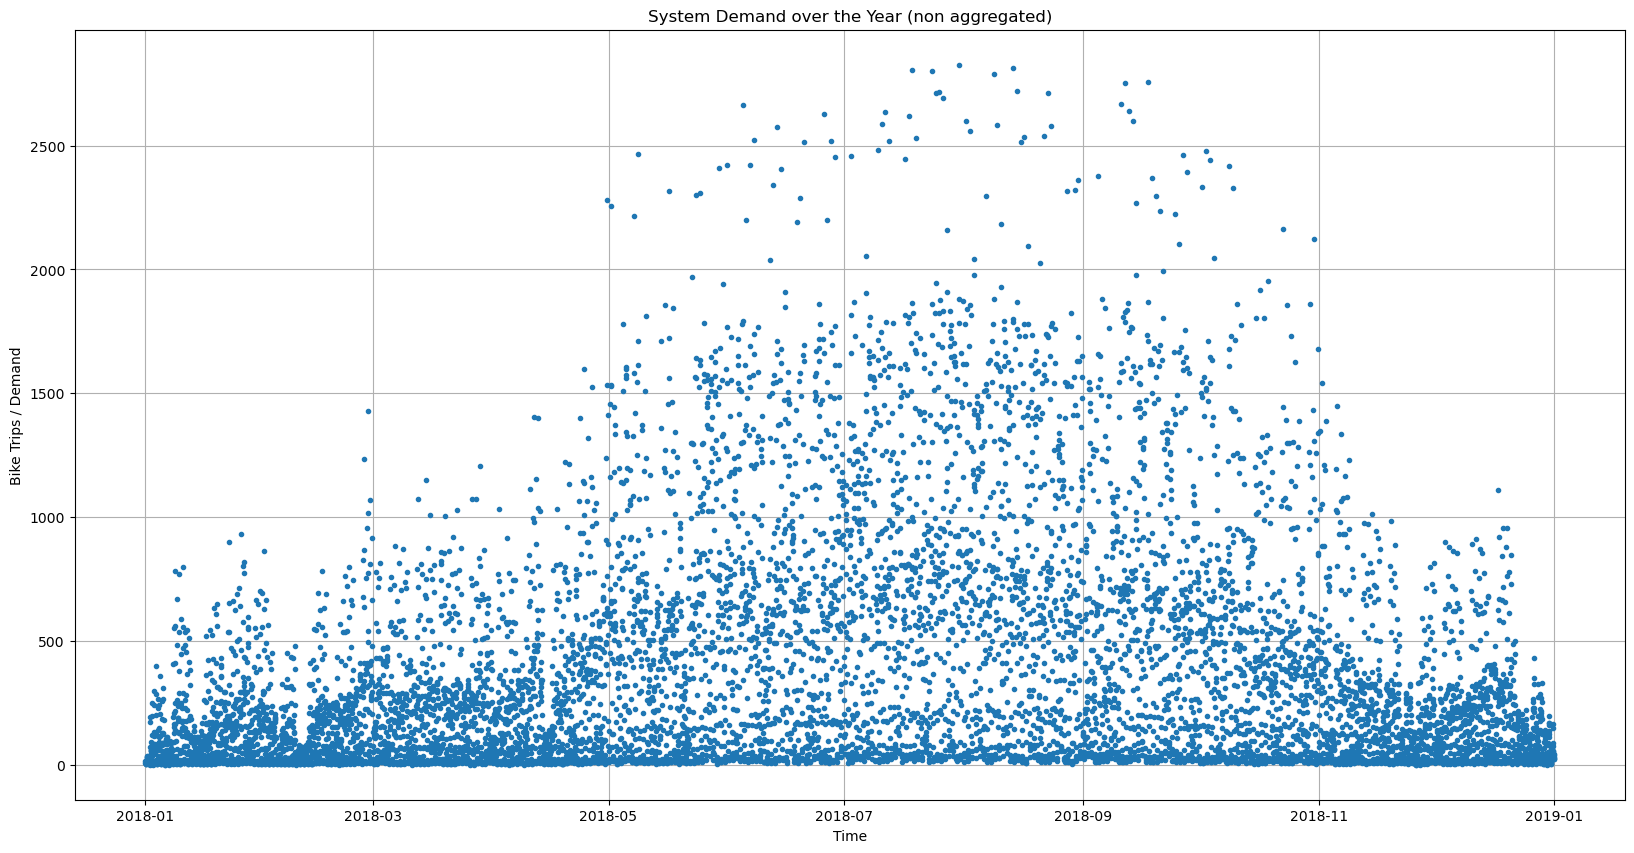

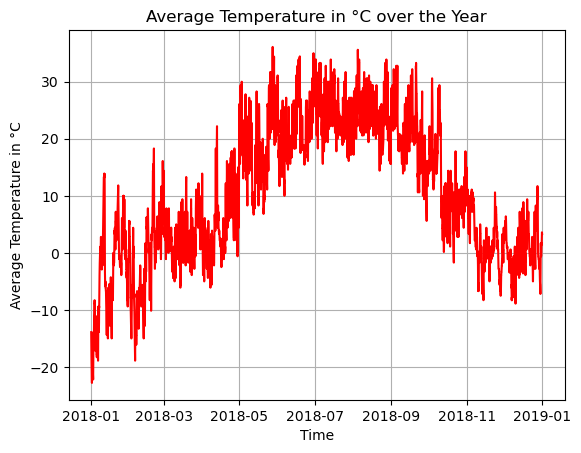

In [110]:
#to visualize our system demand, we create a plot
plt.plot(df_load_weather['start_time'], df_load_weather['Demand'], '.')
plt.title('System Demand over the Year (non aggregated)')
plt.xlabel('Time')
plt.ylabel('Bike Trips / Demand')
plt.grid(True)

plt.gcf().set_size_inches(20,10)
plt.show()

plt.plot(df_load_weather['start_time'],df_load_weather['avg_temp'], "r-")
plt.title('Average Temperature in °C over the Year')
plt.xlabel('Time')
plt.ylabel('Average Temperature in °C')
plt.grid(True)
plt.show()


In [111]:
# Feature Selection

# We start by performing a Lasso (L1 regularization) regression on our dataset, in order to obtain the importance
# of our features

#We start calculating the Pearson's correlation of each column with the demand to determine, which features
# are actually worth keeping for the regression
#df_load_weather.drop('level_0', axis= 1, inplace = True)
df_load_weather.head()

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,isHoliday,day_of_Week,sin_day_of_Week,cos_day_of_Week,season,in_rush_Hour,prev_Demand
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000,1.000000,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,NaN
1,2018-01-01 01:00:00,14,0.0,-15.0,1,0.258819,0.965926,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,7.0
2,2018-01-01 02:00:00,10,0.0,-15.6,2,0.500000,0.866025,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,14.0
3,2018-01-01 03:00:00,2,0.0,-16.7,3,0.707107,0.707107,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,10.0
4,2018-01-01 04:00:00,2,0.0,-17.2,4,0.866025,0.500000,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,2.0


In [20]:
# First of all we split the data into our training and testing data, since we only compute our correlation
# and later regression also on our training data

# trying lasso regression for eliminating useless features and avoid overfitting



# x are out features
X = df_load_weather.drop('Demand', axis = 1)

# setting start_time as index, data is saved in start_day and start_month
# regression does not work with datetime objects, which is why we only save it as index and the acutal data (day, month, hour)
# as integer

X.set_index('start_time',inplace = True)
#print(X)

#X['start_time'] = pd.to_datetime(X['start_time'])
# y is our label
y = df_load_weather['Demand']

#splitting data into training and testing data, with testing data being 30% of our dataset
#random_state just a variable for randomizing which values are used for training and which are used for testing


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#Fill nan values in X_train with the mean of X_train, incase there are nan values
X_train.fillna(X_train.mean(), inplace=True)


# since lasso regression puts a lot of penalty on high magnitudes of features, scaling our features is essential
# in order to obtain precise results
# Normalizing of features: 

pipeline = Pipeline([('scaler',StandardScaler()),
                    ('model', Lasso())
                     ])

# for finding the optimal value for lamda (also called alpha in a lot of literature) we utilize a Grid Search
# GridSearch basically performs a 5-fold cross-validation on our training data in order to locate the optimal value
# for lambda (or in python alpha)
# Here we need to utilize the pipeline to include featurescaling into our lasso regression
# Gridsearch more like a shortcut to instantly find the best alpha, plotting for mse and r-squared will be shown with
# Regressions we actually use for predictions. Here we only want to find the most important features in the
# fastest way possible
# Finding optimal value for lambda = Hyperparameter Tuning for Lasso regression (since lambda is the only hyperparameter in a Lasso regression)

search = GridSearchCV (pipeline,
                    {'model__alpha':np.arange(0.1, 50, 0.1)},
                      cv = 5, scoring = "neg_mean_squared_error", verbose=3
                      )

# when increasing the lambda range from 10 to 50, the optimal value remains at 0.1
# we can conclude that the optimal lambda value for this data set is indeed 0.1 => very limited regularization

search.fit(X_train, y_train)
print (search.best_params_)

Fitting 5 folds for each of 499 candidates, totalling 2495 fits
[CV 1/5] END .............model__alpha=0.1;, score=-34388.866 total time=   0.0s
[CV 2/5] END .............model__alpha=0.1;, score=-47053.589 total time=   0.0s
[CV 3/5] END .............model__alpha=0.1;, score=-42533.635 total time=   0.0s
[CV 4/5] END .............model__alpha=0.1;, score=-44312.835 total time=   0.0s
[CV 5/5] END .............model__alpha=0.1;, score=-43099.533 total time=   0.0s
[CV 1/5] END .............model__alpha=0.2;, score=-34387.309 total time=   0.1s
[CV 2/5] END .............model__alpha=0.2;, score=-47055.499 total time=   0.1s
[CV 3/5] END .............model__alpha=0.2;, score=-42518.945 total time=   0.1s
[CV 4/5] END .............model__alpha=0.2;, score=-44320.538 total time=   0.0s
[CV 5/5] END .............model__alpha=0.2;, score=-43098.713 total time=   0.0s
[CV 1/5] END model__alpha=0.30000000000000004;, score=-34386.657 total time=   0.0s
[CV 2/5] END model__alpha=0.30000000000000

[CV 1/5] END .............model__alpha=2.2;, score=-34471.737 total time=   0.0s
[CV 2/5] END .............model__alpha=2.2;, score=-47233.502 total time=   0.0s
[CV 3/5] END .............model__alpha=2.2;, score=-42263.169 total time=   0.0s
[CV 4/5] END .............model__alpha=2.2;, score=-44671.062 total time=   0.0s
[CV 5/5] END .............model__alpha=2.2;, score=-43198.347 total time=   0.0s
[CV 1/5] END model__alpha=2.3000000000000003;, score=-34476.226 total time=   0.0s
[CV 2/5] END model__alpha=2.3000000000000003;, score=-47249.241 total time=   0.0s
[CV 3/5] END model__alpha=2.3000000000000003;, score=-42256.834 total time=   0.0s
[CV 4/5] END model__alpha=2.3000000000000003;, score=-44693.398 total time=   0.0s
[CV 5/5] END model__alpha=2.3000000000000003;, score=-43207.795 total time=   0.0s
[CV 1/5] END model__alpha=2.4000000000000004;, score=-34481.069 total time=   0.0s
[CV 2/5] END model__alpha=2.4000000000000004;, score=-47265.433 total time=   0.0s
[CV 3/5] END m

[CV 1/5] END model__alpha=4.3999999999999995;, score=-34652.066 total time=   0.0s
[CV 2/5] END model__alpha=4.3999999999999995;, score=-47623.216 total time=   0.0s
[CV 3/5] END model__alpha=4.3999999999999995;, score=-42194.089 total time=   0.0s
[CV 4/5] END model__alpha=4.3999999999999995;, score=-45248.991 total time=   0.0s
[CV 5/5] END model__alpha=4.3999999999999995;, score=-43446.908 total time=   0.0s
[CV 1/5] END .............model__alpha=4.5;, score=-34664.323 total time=   0.0s
[CV 2/5] END .............model__alpha=4.5;, score=-47643.028 total time=   0.0s
[CV 3/5] END .............model__alpha=4.5;, score=-42195.375 total time=   0.0s
[CV 4/5] END .............model__alpha=4.5;, score=-45279.562 total time=   0.0s
[CV 5/5] END .............model__alpha=4.5;, score=-43461.668 total time=   0.0s
[CV 1/5] END .............model__alpha=4.6;, score=-34676.932 total time=   0.0s
[CV 2/5] END .............model__alpha=4.6;, score=-47663.173 total time=   0.0s
[CV 3/5] END .....

[CV 4/5] END .............model__alpha=6.6;, score=-45686.684 total time=   0.0s
[CV 5/5] END .............model__alpha=6.6;, score=-43710.164 total time=   0.0s
[CV 1/5] END .............model__alpha=6.7;, score=-34862.459 total time=   0.0s
[CV 2/5] END .............model__alpha=6.7;, score=-47905.231 total time=   0.0s
[CV 3/5] END .............model__alpha=6.7;, score=-42266.898 total time=   0.0s
[CV 4/5] END .............model__alpha=6.7;, score=-45707.528 total time=   0.0s
[CV 5/5] END .............model__alpha=6.7;, score=-43719.150 total time=   0.0s
[CV 1/5] END .............model__alpha=6.8;, score=-34870.174 total time=   0.0s
[CV 2/5] END .............model__alpha=6.8;, score=-47915.798 total time=   0.0s
[CV 3/5] END .............model__alpha=6.8;, score=-42270.020 total time=   0.0s
[CV 4/5] END .............model__alpha=6.8;, score=-45727.830 total time=   0.0s
[CV 5/5] END .............model__alpha=6.8;, score=-43728.269 total time=   0.0s
[CV 1/5] END .............mo

[CV 5/5] END .............model__alpha=8.7;, score=-43926.958 total time=   0.0s
[CV 1/5] END .............model__alpha=8.8;, score=-35032.482 total time=   0.0s
[CV 2/5] END .............model__alpha=8.8;, score=-48156.531 total time=   0.0s
[CV 3/5] END .............model__alpha=8.8;, score=-42370.699 total time=   0.0s
[CV 4/5] END .............model__alpha=8.8;, score=-46150.654 total time=   0.0s
[CV 5/5] END .............model__alpha=8.8;, score=-43938.747 total time=   0.0s
[CV 1/5] END .............model__alpha=8.9;, score=-35041.717 total time=   0.0s
[CV 2/5] END .............model__alpha=8.9;, score=-48170.036 total time=   0.0s
[CV 3/5] END .............model__alpha=8.9;, score=-42377.627 total time=   0.0s
[CV 4/5] END .............model__alpha=8.9;, score=-46173.504 total time=   0.0s
[CV 5/5] END .............model__alpha=8.9;, score=-43950.669 total time=   0.0s
[CV 1/5] END .............model__alpha=9.0;, score=-35051.081 total time=   0.0s
[CV 2/5] END .............mo

[CV 1/5] END ............model__alpha=11.1;, score=-35277.541 total time=   0.0s
[CV 2/5] END ............model__alpha=11.1;, score=-48498.195 total time=   0.0s
[CV 3/5] END ............model__alpha=11.1;, score=-42582.736 total time=   0.0s
[CV 4/5] END ............model__alpha=11.1;, score=-46608.968 total time=   0.1s
[CV 5/5] END ............model__alpha=11.1;, score=-44201.062 total time=   0.0s
[CV 1/5] END model__alpha=11.200000000000001;, score=-35289.744 total time=   0.0s
[CV 2/5] END model__alpha=11.200000000000001;, score=-48513.189 total time=   0.1s
[CV 3/5] END model__alpha=11.200000000000001;, score=-42594.011 total time=   0.0s
[CV 4/5] END model__alpha=11.200000000000001;, score=-46620.038 total time=   0.0s
[CV 5/5] END model__alpha=11.200000000000001;, score=-44213.426 total time=   0.0s
[CV 1/5] END ............model__alpha=11.3;, score=-35302.077 total time=   0.0s
[CV 2/5] END ............model__alpha=11.3;, score=-48528.311 total time=   0.0s
[CV 3/5] END .....

[CV 5/5] END ............model__alpha=13.1;, score=-44471.677 total time=   0.0s
[CV 1/5] END model__alpha=13.200000000000001;, score=-35495.521 total time=   0.0s
[CV 2/5] END model__alpha=13.200000000000001;, score=-48839.903 total time=   0.0s
[CV 3/5] END model__alpha=13.200000000000001;, score=-42819.132 total time=   0.0s
[CV 4/5] END model__alpha=13.200000000000001;, score=-46859.029 total time=   0.0s
[CV 5/5] END model__alpha=13.200000000000001;, score=-44486.490 total time=   0.1s
[CV 1/5] END ............model__alpha=13.3;, score=-35503.229 total time=   0.1s
[CV 2/5] END ............model__alpha=13.3;, score=-48857.581 total time=   0.1s
[CV 3/5] END ............model__alpha=13.3;, score=-42826.891 total time=   0.0s
[CV 4/5] END ............model__alpha=13.3;, score=-46871.856 total time=   0.0s
[CV 5/5] END ............model__alpha=13.3;, score=-44501.425 total time=   0.0s
[CV 1/5] END ............model__alpha=13.4;, score=-35511.029 total time=   0.1s
[CV 2/5] END .....

[CV 5/5] END ............model__alpha=15.4;, score=-44766.976 total time=   0.0s
[CV 1/5] END ............model__alpha=15.5;, score=-35686.568 total time=   0.0s
[CV 2/5] END ............model__alpha=15.5;, score=-49200.708 total time=   0.0s
[CV 3/5] END ............model__alpha=15.5;, score=-42991.007 total time=   0.0s
[CV 4/5] END ............model__alpha=15.5;, score=-47175.139 total time=   0.0s
[CV 5/5] END ............model__alpha=15.5;, score=-44779.183 total time=   0.0s
[CV 1/5] END ............model__alpha=15.6;, score=-35695.503 total time=   0.0s
[CV 2/5] END ............model__alpha=15.6;, score=-49216.160 total time=   0.0s
[CV 3/5] END ............model__alpha=15.6;, score=-42999.087 total time=   0.0s
[CV 4/5] END ............model__alpha=15.6;, score=-47189.884 total time=   0.0s
[CV 5/5] END ............model__alpha=15.6;, score=-44791.462 total time=   0.0s
[CV 1/5] END model__alpha=15.700000000000001;, score=-35704.516 total time=   0.0s
[CV 2/5] END model__alpha=

[CV 4/5] END model__alpha=16.500000000000004;, score=-47326.339 total time=   0.0s
[CV 5/5] END model__alpha=16.500000000000004;, score=-44905.132 total time=   0.0s
[CV 1/5] END ............model__alpha=16.6;, score=-35789.082 total time=   0.0s
[CV 2/5] END ............model__alpha=16.6;, score=-49374.911 total time=   0.0s
[CV 3/5] END ............model__alpha=16.6;, score=-43083.593 total time=   0.0s
[CV 4/5] END ............model__alpha=16.6;, score=-47341.917 total time=   0.0s
[CV 5/5] END ............model__alpha=16.6;, score=-44918.128 total time=   0.0s
[CV 1/5] END model__alpha=16.700000000000003;, score=-35798.862 total time=   0.0s
[CV 2/5] END model__alpha=16.700000000000003;, score=-49391.210 total time=   0.1s
[CV 3/5] END model__alpha=16.700000000000003;, score=-43092.473 total time=   0.1s
[CV 4/5] END model__alpha=16.700000000000003;, score=-47357.579 total time=   0.0s
[CV 5/5] END model__alpha=16.700000000000003;, score=-44931.196 total time=   0.1s
[CV 1/5] END .

[CV 5/5] END ............model__alpha=17.6;, score=-45052.033 total time=   0.0s
[CV 1/5] END model__alpha=17.700000000000003;, score=-35900.879 total time=   0.0s
[CV 2/5] END model__alpha=17.700000000000003;, score=-49558.431 total time=   0.0s
[CV 3/5] END model__alpha=17.700000000000003;, score=-43185.258 total time=   0.1s
[CV 4/5] END model__alpha=17.700000000000003;, score=-47518.886 total time=   0.1s
[CV 5/5] END model__alpha=17.700000000000003;, score=-45065.818 total time=   0.1s
[CV 1/5] END ............model__alpha=17.8;, score=-35911.502 total time=   0.1s
[CV 2/5] END ............model__alpha=17.8;, score=-49575.576 total time=   0.0s
[CV 3/5] END ............model__alpha=17.8;, score=-43194.935 total time=   0.0s
[CV 4/5] END ............model__alpha=17.8;, score=-47535.465 total time=   0.0s
[CV 5/5] END ............model__alpha=17.8;, score=-45079.674 total time=   0.0s
[CV 1/5] END model__alpha=17.900000000000002;, score=-35922.203 total time=   0.0s
[CV 2/5] END mod

[CV 1/5] END model__alpha=19.800000000000004;, score=-36140.077 total time=   0.0s
[CV 2/5] END model__alpha=19.800000000000004;, score=-49934.616 total time=   0.0s
[CV 3/5] END model__alpha=19.800000000000004;, score=-43342.736 total time=   0.0s
[CV 4/5] END model__alpha=19.800000000000004;, score=-47884.464 total time=   0.1s
[CV 5/5] END model__alpha=19.800000000000004;, score=-45371.862 total time=   0.1s
[CV 1/5] END model__alpha=19.900000000000002;, score=-36152.311 total time=   0.0s
[CV 2/5] END model__alpha=19.900000000000002;, score=-49953.379 total time=   0.0s
[CV 3/5] END model__alpha=19.900000000000002;, score=-43348.809 total time=   0.0s
[CV 4/5] END model__alpha=19.900000000000002;, score=-47902.795 total time=   0.1s
[CV 5/5] END model__alpha=19.900000000000002;, score=-45387.225 total time=   0.1s
[CV 1/5] END model__alpha=20.000000000000004;, score=-36164.622 total time=   0.1s
[CV 2/5] END model__alpha=20.000000000000004;, score=-49972.218 total time=   0.1s
[CV 

[CV 3/5] END ............model__alpha=20.6;, score=-43393.902 total time=   0.0s
[CV 4/5] END ............model__alpha=20.6;, score=-48033.441 total time=   0.0s
[CV 5/5] END ............model__alpha=20.6;, score=-45490.187 total time=   0.0s
[CV 1/5] END model__alpha=20.700000000000003;, score=-36252.945 total time=   0.0s
[CV 2/5] END model__alpha=20.700000000000003;, score=-50106.248 total time=   0.0s
[CV 3/5] END model__alpha=20.700000000000003;, score=-43401.341 total time=   0.0s
[CV 4/5] END model__alpha=20.700000000000003;, score=-48052.439 total time=   0.0s
[CV 5/5] END model__alpha=20.700000000000003;, score=-45501.964 total time=   0.0s
[CV 1/5] END model__alpha=20.800000000000004;, score=-36265.870 total time=   0.0s
[CV 2/5] END model__alpha=20.800000000000004;, score=-50125.703 total time=   0.0s
[CV 3/5] END model__alpha=20.800000000000004;, score=-43408.166 total time=   0.0s
[CV 4/5] END model__alpha=20.800000000000004;, score=-48071.519 total time=   0.0s
[CV 5/5] E

[CV 1/5] END model__alpha=22.000000000000004;, score=-36383.455 total time=   0.0s
[CV 2/5] END model__alpha=22.000000000000004;, score=-50365.168 total time=   0.0s
[CV 3/5] END model__alpha=22.000000000000004;, score=-43495.143 total time=   0.0s
[CV 4/5] END model__alpha=22.000000000000004;, score=-48273.818 total time=   0.0s
[CV 5/5] END model__alpha=22.000000000000004;, score=-45664.373 total time=   0.0s
[CV 1/5] END ............model__alpha=22.1;, score=-36394.055 total time=   0.0s
[CV 2/5] END ............model__alpha=22.1;, score=-50385.624 total time=   0.1s
[CV 3/5] END ............model__alpha=22.1;, score=-43502.778 total time=   0.0s
[CV 4/5] END ............model__alpha=22.1;, score=-48290.422 total time=   0.0s
[CV 5/5] END ............model__alpha=22.1;, score=-45677.182 total time=   0.0s
[CV 1/5] END model__alpha=22.200000000000003;, score=-36404.120 total time=   0.0s
[CV 2/5] END model__alpha=22.200000000000003;, score=-50406.157 total time=   0.1s
[CV 3/5] END m

[CV 2/5] END model__alpha=24.200000000000003;, score=-50797.982 total time=   0.0s
[CV 3/5] END model__alpha=24.200000000000003;, score=-43673.886 total time=   0.0s
[CV 4/5] END model__alpha=24.200000000000003;, score=-48658.018 total time=   0.0s
[CV 5/5] END model__alpha=24.200000000000003;, score=-45960.523 total time=   0.0s
[CV 1/5] END model__alpha=24.300000000000004;, score=-36631.097 total time=   0.0s
[CV 2/5] END model__alpha=24.300000000000004;, score=-50817.908 total time=   0.0s
[CV 3/5] END model__alpha=24.300000000000004;, score=-43682.142 total time=   0.0s
[CV 4/5] END model__alpha=24.300000000000004;, score=-48676.221 total time=   0.0s
[CV 5/5] END model__alpha=24.300000000000004;, score=-45974.592 total time=   0.0s
[CV 1/5] END model__alpha=24.400000000000002;, score=-36642.491 total time=   0.0s
[CV 2/5] END model__alpha=24.400000000000002;, score=-50837.512 total time=   0.0s
[CV 3/5] END model__alpha=24.400000000000002;, score=-43691.264 total time=   0.0s
[CV 

[CV 2/5] END model__alpha=24.700000000000003;, score=-50896.715 total time=   0.0s
[CV 3/5] END model__alpha=24.700000000000003;, score=-43715.878 total time=   0.0s
[CV 4/5] END model__alpha=24.700000000000003;, score=-48750.388 total time=   0.0s
[CV 5/5] END model__alpha=24.700000000000003;, score=-46031.428 total time=   0.0s
[CV 1/5] END model__alpha=24.800000000000004;, score=-36688.641 total time=   0.0s
[CV 2/5] END model__alpha=24.800000000000004;, score=-50916.595 total time=   0.0s
[CV 3/5] END model__alpha=24.800000000000004;, score=-43725.161 total time=   0.0s
[CV 4/5] END model__alpha=24.800000000000004;, score=-48768.929 total time=   0.0s
[CV 5/5] END model__alpha=24.800000000000004;, score=-46045.785 total time=   0.0s
[CV 1/5] END model__alpha=24.900000000000002;, score=-36700.322 total time=   0.0s
[CV 2/5] END model__alpha=24.900000000000002;, score=-50936.538 total time=   0.0s
[CV 3/5] END model__alpha=24.900000000000002;, score=-43733.933 total time=   0.0s
[CV 

[CV 1/5] END model__alpha=26.500000000000004;, score=-36895.787 total time=   0.0s
[CV 2/5] END model__alpha=26.500000000000004;, score=-51264.939 total time=   0.0s
[CV 3/5] END model__alpha=26.500000000000004;, score=-43886.264 total time=   0.0s
[CV 4/5] END model__alpha=26.500000000000004;, score=-49095.042 total time=   0.0s
[CV 5/5] END model__alpha=26.500000000000004;, score=-46298.940 total time=   0.0s
[CV 1/5] END ............model__alpha=26.6;, score=-36908.448 total time=   0.0s
[CV 2/5] END ............model__alpha=26.6;, score=-51285.954 total time=   0.0s
[CV 3/5] END ............model__alpha=26.6;, score=-43897.188 total time=   0.0s
[CV 4/5] END ............model__alpha=26.6;, score=-49114.793 total time=   0.0s
[CV 5/5] END ............model__alpha=26.6;, score=-46314.315 total time=   0.0s
[CV 1/5] END model__alpha=26.700000000000003;, score=-36921.179 total time=   0.0s
[CV 2/5] END model__alpha=26.700000000000003;, score=-51306.198 total time=   0.0s
[CV 3/5] END m

[CV 4/5] END model__alpha=26.700000000000003;, score=-49134.610 total time=   0.0s
[CV 5/5] END model__alpha=26.700000000000003;, score=-46329.747 total time=   0.0s
[CV 1/5] END model__alpha=26.800000000000004;, score=-36933.978 total time=   0.0s
[CV 2/5] END model__alpha=26.800000000000004;, score=-51327.005 total time=   0.0s
[CV 3/5] END model__alpha=26.800000000000004;, score=-43917.432 total time=   0.0s
[CV 4/5] END model__alpha=26.800000000000004;, score=-49154.495 total time=   0.0s
[CV 5/5] END model__alpha=26.800000000000004;, score=-46345.235 total time=   0.0s
[CV 1/5] END model__alpha=26.900000000000002;, score=-36946.833 total time=   0.0s
[CV 2/5] END model__alpha=26.900000000000002;, score=-51347.251 total time=   0.0s
[CV 3/5] END model__alpha=26.900000000000002;, score=-43927.639 total time=   0.0s
[CV 4/5] END model__alpha=26.900000000000002;, score=-49174.446 total time=   0.0s
[CV 5/5] END model__alpha=26.900000000000002;, score=-46360.779 total time=   0.0s
[CV 

[CV 3/5] END ............model__alpha=28.6;, score=-44110.017 total time=   0.0s
[CV 4/5] END ............model__alpha=28.6;, score=-49524.447 total time=   0.0s
[CV 5/5] END ............model__alpha=28.6;, score=-46633.971 total time=   0.0s
[CV 1/5] END model__alpha=28.700000000000003;, score=-37189.070 total time=   0.0s
[CV 2/5] END model__alpha=28.700000000000003;, score=-51725.275 total time=   0.0s
[CV 3/5] END model__alpha=28.700000000000003;, score=-44121.265 total time=   0.1s
[CV 4/5] END model__alpha=28.700000000000003;, score=-49545.449 total time=   0.0s
[CV 5/5] END model__alpha=28.700000000000003;, score=-46650.509 total time=   0.0s
[CV 1/5] END model__alpha=28.800000000000004;, score=-37202.962 total time=   0.0s
[CV 2/5] END model__alpha=28.800000000000004;, score=-51746.822 total time=   0.0s
[CV 3/5] END model__alpha=28.800000000000004;, score=-44132.571 total time=   0.0s


[CV 4/5] END model__alpha=28.800000000000004;, score=-49566.495 total time=   0.0s
[CV 5/5] END model__alpha=28.800000000000004;, score=-46667.104 total time=   0.0s
[CV 1/5] END model__alpha=28.900000000000002;, score=-37216.912 total time=   0.0s
[CV 2/5] END model__alpha=28.900000000000002;, score=-51768.428 total time=   0.0s
[CV 3/5] END model__alpha=28.900000000000002;, score=-44143.935 total time=   0.0s
[CV 4/5] END model__alpha=28.900000000000002;, score=-49587.701 total time=   0.0s
[CV 5/5] END model__alpha=28.900000000000002;, score=-46683.768 total time=   0.0s
[CV 1/5] END model__alpha=29.000000000000004;, score=-37230.918 total time=   0.0s
[CV 2/5] END model__alpha=29.000000000000004;, score=-51790.097 total time=   0.0s
[CV 3/5] END model__alpha=29.000000000000004;, score=-44155.357 total time=   0.0s
[CV 4/5] END model__alpha=29.000000000000004;, score=-49608.974 total time=   0.0s
[CV 5/5] END model__alpha=29.000000000000004;, score=-46700.493 total time=   0.0s
[CV 

[CV 4/5] END model__alpha=30.700000000000003;, score=-49978.068 total time=   0.0s
[CV 5/5] END model__alpha=30.700000000000003;, score=-46994.076 total time=   0.0s
[CV 1/5] END model__alpha=30.800000000000004;, score=-37489.086 total time=   0.0s
[CV 2/5] END model__alpha=30.800000000000004;, score=-52192.120 total time=   0.0s
[CV 3/5] END model__alpha=30.800000000000004;, score=-44370.977 total time=   0.0s
[CV 4/5] END model__alpha=30.800000000000004;, score=-50000.269 total time=   0.0s
[CV 5/5] END model__alpha=30.800000000000004;, score=-47011.771 total time=   0.0s
[CV 1/5] END model__alpha=30.900000000000002;, score=-37503.894 total time=   0.0s
[CV 2/5] END model__alpha=30.900000000000002;, score=-52215.000 total time=   0.0s


[CV 3/5] END model__alpha=30.900000000000002;, score=-44383.508 total time=   0.0s
[CV 4/5] END model__alpha=30.900000000000002;, score=-50022.533 total time=   0.0s
[CV 5/5] END model__alpha=30.900000000000002;, score=-47029.521 total time=   0.0s
[CV 1/5] END model__alpha=31.000000000000004;, score=-37518.757 total time=   0.0s
[CV 2/5] END model__alpha=31.000000000000004;, score=-52237.940 total time=   0.0s
[CV 3/5] END model__alpha=31.000000000000004;, score=-44396.096 total time=   0.0s
[CV 4/5] END model__alpha=31.000000000000004;, score=-50044.862 total time=   0.0s
[CV 5/5] END model__alpha=31.000000000000004;, score=-47047.327 total time=   0.0s
[CV 1/5] END ............model__alpha=31.1;, score=-37533.676 total time=   0.0s
[CV 2/5] END ............model__alpha=31.1;, score=-52260.939 total time=   0.0s
[CV 3/5] END ............model__alpha=31.1;, score=-44408.741 total time=   0.0s
[CV 4/5] END ............model__alpha=31.1;, score=-50067.255 total time=   0.0s
[CV 5/5] END

[CV 4/5] END model__alpha=32.800000000000004;, score=-50459.513 total time=   0.0s
[CV 5/5] END model__alpha=32.800000000000004;, score=-47374.638 total time=   0.0s
[CV 1/5] END model__alpha=32.900000000000006;, score=-37813.796 total time=   0.0s
[CV 2/5] END model__alpha=32.900000000000006;, score=-52685.096 total time=   0.0s
[CV 3/5] END model__alpha=32.900000000000006;, score=-44646.263 total time=   0.0s
[CV 4/5] END model__alpha=32.900000000000006;, score=-50483.103 total time=   0.0s
[CV 5/5] END model__alpha=32.900000000000006;, score=-47393.378 total time=   0.0s


[CV 1/5] END ............model__alpha=33.0;, score=-37829.847 total time=   0.0s
[CV 2/5] END ............model__alpha=33.0;, score=-52709.231 total time=   0.0s
[CV 3/5] END ............model__alpha=33.0;, score=-44660.008 total time=   0.0s
[CV 4/5] END ............model__alpha=33.0;, score=-50506.759 total time=   0.0s
[CV 5/5] END ............model__alpha=33.0;, score=-47412.176 total time=   0.0s
[CV 1/5] END ............model__alpha=33.1;, score=-37845.955 total time=   0.0s
[CV 2/5] END ............model__alpha=33.1;, score=-52733.424 total time=   0.0s
[CV 3/5] END ............model__alpha=33.1;, score=-44673.811 total time=   0.0s
[CV 4/5] END ............model__alpha=33.1;, score=-50530.481 total time=   0.0s
[CV 5/5] END ............model__alpha=33.1;, score=-47431.027 total time=   0.0s
[CV 1/5] END ............model__alpha=33.2;, score=-37862.119 total time=   0.0s
[CV 2/5] END ............model__alpha=33.2;, score=-52757.677 total time=   0.0s
[CV 3/5] END ............mod

[CV 1/5] END ............model__alpha=35.0;, score=-38162.573 total time=   0.0s
[CV 2/5] END ............model__alpha=35.0;, score=-53204.427 total time=   0.0s
[CV 3/5] END ............model__alpha=35.0;, score=-44947.125 total time=   0.0s
[CV 4/5] END ............model__alpha=35.0;, score=-50993.481 total time=   0.0s
[CV 5/5] END ............model__alpha=35.0;, score=-47799.527 total time=   0.0s


[CV 1/5] END ............model__alpha=35.1;, score=-38179.796 total time=   0.0s
[CV 2/5] END ............model__alpha=35.1;, score=-53229.813 total time=   0.0s
[CV 3/5] END ............model__alpha=35.1;, score=-44962.089 total time=   0.0s
[CV 4/5] END ............model__alpha=35.1;, score=-51018.494 total time=   0.0s
[CV 5/5] END ............model__alpha=35.1;, score=-47819.466 total time=   0.0s
[CV 1/5] END ............model__alpha=35.2;, score=-38197.076 total time=   0.0s
[CV 2/5] END ............model__alpha=35.2;, score=-53255.257 total time=   0.0s
[CV 3/5] END ............model__alpha=35.2;, score=-44977.111 total time=   0.0s
[CV 4/5] END ............model__alpha=35.2;, score=-51043.571 total time=   0.0s
[CV 5/5] END ............model__alpha=35.2;, score=-47839.460 total time=   0.0s
[CV 1/5] END model__alpha=35.300000000000004;, score=-38214.411 total time=   0.0s
[CV 2/5] END model__alpha=35.300000000000004;, score=-53280.761 total time=   0.0s
[CV 3/5] END model__alph

[CV 1/5] END ............model__alpha=37.1;, score=-38535.961 total time=   0.0s
[CV 2/5] END ............model__alpha=37.1;, score=-53750.018 total time=   0.0s
[CV 3/5] END ............model__alpha=37.1;, score=-45273.530 total time=   0.0s
[CV 4/5] END ............model__alpha=37.1;, score=-51532.229 total time=   0.0s
[CV 5/5] END ............model__alpha=37.1;, score=-48229.633 total time=   0.0s
[CV 1/5] END ............model__alpha=37.2;, score=-38554.353 total time=   0.0s


[CV 2/5] END ............model__alpha=37.2;, score=-53776.655 total time=   0.0s
[CV 3/5] END ............model__alpha=37.2;, score=-45289.710 total time=   0.0s
[CV 4/5] END ............model__alpha=37.2;, score=-51558.590 total time=   0.0s
[CV 5/5] END ............model__alpha=37.2;, score=-48250.713 total time=   0.0s
[CV 1/5] END model__alpha=37.300000000000004;, score=-38572.801 total time=   0.0s
[CV 2/5] END model__alpha=37.300000000000004;, score=-53803.351 total time=   0.0s
[CV 3/5] END model__alpha=37.300000000000004;, score=-45305.948 total time=   0.0s
[CV 4/5] END model__alpha=37.300000000000004;, score=-51585.016 total time=   0.0s
[CV 5/5] END model__alpha=37.300000000000004;, score=-48271.848 total time=   0.0s
[CV 1/5] END model__alpha=37.400000000000006;, score=-38591.304 total time=   0.0s
[CV 2/5] END model__alpha=37.400000000000006;, score=-53830.107 total time=   0.0s
[CV 3/5] END model__alpha=37.400000000000006;, score=-45322.243 total time=   0.0s
[CV 4/5] END

[CV 3/5] END ............model__alpha=39.1;, score=-45608.124 total time=   0.0s
[CV 4/5] END ............model__alpha=39.1;, score=-52071.706 total time=   0.0s
[CV 5/5] END ............model__alpha=39.1;, score=-48661.518 total time=   0.0s
[CV 1/5] END ............model__alpha=39.2;, score=-38933.893 total time=   0.0s
[CV 2/5] END ............model__alpha=39.2;, score=-54321.877 total time=   0.0s
[CV 3/5] END ............model__alpha=39.2;, score=-45625.462 total time=   0.0s


[CV 4/5] END ............model__alpha=39.2;, score=-52099.356 total time=   0.0s
[CV 5/5] END ............model__alpha=39.2;, score=-48683.680 total time=   0.0s
[CV 1/5] END model__alpha=39.300000000000004;, score=-38953.454 total time=   0.0s
[CV 2/5] END model__alpha=39.300000000000004;, score=-54349.763 total time=   0.0s
[CV 3/5] END model__alpha=39.300000000000004;, score=-45642.857 total time=   0.0s
[CV 4/5] END model__alpha=39.300000000000004;, score=-52127.070 total time=   0.0s
[CV 5/5] END model__alpha=39.300000000000004;, score=-48705.897 total time=   0.0s
[CV 1/5] END model__alpha=39.400000000000006;, score=-38973.070 total time=   0.0s
[CV 2/5] END model__alpha=39.400000000000006;, score=-54377.709 total time=   0.0s
[CV 3/5] END model__alpha=39.400000000000006;, score=-45660.310 total time=   0.0s
[CV 4/5] END model__alpha=39.400000000000006;, score=-52154.849 total time=   0.0s
[CV 5/5] END model__alpha=39.400000000000006;, score=-48728.168 total time=   0.0s
[CV 1/5]

[CV 1/5] END ............model__alpha=41.2;, score=-39335.683 total time=   0.0s
[CV 2/5] END ............model__alpha=41.2;, score=-54890.909 total time=   0.0s
[CV 3/5] END ............model__alpha=41.2;, score=-45984.356 total time=   0.0s
[CV 4/5] END ............model__alpha=41.2;, score=-52665.873 total time=   0.0s
[CV 5/5] END ............model__alpha=41.2;, score=-49138.285 total time=   0.0s


[CV 1/5] END model__alpha=41.300000000000004;, score=-39356.357 total time=   0.0s
[CV 2/5] END model__alpha=41.300000000000004;, score=-54919.985 total time=   0.0s
[CV 3/5] END model__alpha=41.300000000000004;, score=-46002.909 total time=   0.0s
[CV 4/5] END model__alpha=41.300000000000004;, score=-52694.875 total time=   0.0s
[CV 5/5] END model__alpha=41.300000000000004;, score=-49161.583 total time=   0.0s
[CV 1/5] END model__alpha=41.400000000000006;, score=-39377.086 total time=   0.0s
[CV 2/5] END model__alpha=41.400000000000006;, score=-54949.121 total time=   0.0s
[CV 3/5] END model__alpha=41.400000000000006;, score=-46021.519 total time=   0.0s
[CV 4/5] END model__alpha=41.400000000000006;, score=-52723.940 total time=   0.0s
[CV 5/5] END model__alpha=41.400000000000006;, score=-49184.935 total time=   0.0s
[CV 1/5] END model__alpha=41.50000000000001;, score=-39397.872 total time=   0.0s
[CV 2/5] END model__alpha=41.50000000000001;, score=-54978.317 total time=   0.0s
[CV 3/

[CV 5/5] END model__alpha=43.300000000000004;, score=-49638.916 total time=   0.0s
[CV 1/5] END model__alpha=43.400000000000006;, score=-39803.356 total time=   0.0s
[CV 2/5] END model__alpha=43.400000000000006;, score=-55544.349 total time=   0.0s
[CV 3/5] END model__alpha=43.400000000000006;, score=-46405.886 total time=   0.0s
[CV 4/5] END model__alpha=43.400000000000006;, score=-53318.763 total time=   0.0s


[CV 5/5] END model__alpha=43.400000000000006;, score=-49663.352 total time=   0.0s
[CV 1/5] END model__alpha=43.50000000000001;, score=-39825.253 total time=   0.0s
[CV 2/5] END model__alpha=43.50000000000001;, score=-55574.736 total time=   0.0s
[CV 3/5] END model__alpha=43.50000000000001;, score=-46425.712 total time=   0.0s
[CV 4/5] END model__alpha=43.50000000000001;, score=-53349.179 total time=   0.0s
[CV 5/5] END model__alpha=43.50000000000001;, score=-49687.842 total time=   0.0s
[CV 1/5] END ............model__alpha=43.6;, score=-39847.206 total time=   0.0s
[CV 2/5] END ............model__alpha=43.6;, score=-55605.182 total time=   0.0s
[CV 3/5] END ............model__alpha=43.6;, score=-46445.596 total time=   0.0s
[CV 4/5] END ............model__alpha=43.6;, score=-53379.660 total time=   0.0s
[CV 5/5] END ............model__alpha=43.6;, score=-49712.386 total time=   0.0s
[CV 1/5] END ............model__alpha=43.7;, score=-39869.215 total time=   0.0s
[CV 2/5] END ........

[CV 2/5] END model__alpha=45.400000000000006;, score=-56163.395 total time=   0.0s
[CV 3/5] END model__alpha=45.400000000000006;, score=-46813.405 total time=   0.0s
[CV 4/5] END model__alpha=45.400000000000006;, score=-53939.321 total time=   0.0s


[CV 5/5] END model__alpha=45.400000000000006;, score=-50163.439 total time=   0.0s
[CV 1/5] END model__alpha=45.50000000000001;, score=-40274.887 total time=   0.0s
[CV 2/5] END model__alpha=45.50000000000001;, score=-56194.972 total time=   0.0s
[CV 3/5] END model__alpha=45.50000000000001;, score=-46834.389 total time=   0.0s
[CV 4/5] END model__alpha=45.50000000000001;, score=-53971.024 total time=   0.0s
[CV 5/5] END model__alpha=45.50000000000001;, score=-50189.012 total time=   0.0s
[CV 1/5] END ............model__alpha=45.6;, score=-40297.953 total time=   0.0s
[CV 2/5] END ............model__alpha=45.6;, score=-56226.609 total time=   0.0s
[CV 3/5] END ............model__alpha=45.6;, score=-46855.430 total time=   0.0s
[CV 4/5] END ............model__alpha=45.6;, score=-54002.792 total time=   0.0s
[CV 5/5] END ............model__alpha=45.6;, score=-50214.639 total time=   0.0s
[CV 1/5] END ............model__alpha=45.7;, score=-40321.074 total time=   0.0s
[CV 2/5] END ........

[CV 2/5] END model__alpha=47.50000000000001;, score=-56839.019 total time=   0.0s
[CV 3/5] END model__alpha=47.50000000000001;, score=-47266.218 total time=   0.0s
[CV 4/5] END model__alpha=47.50000000000001;, score=-54618.608 total time=   0.0s
[CV 5/5] END model__alpha=47.50000000000001;, score=-50711.835 total time=   0.0s
[CV 1/5] END ............model__alpha=47.6;, score=-40770.958 total time=   0.0s
[CV 2/5] END ............model__alpha=47.6;, score=-56871.846 total time=   0.0s
[CV 3/5] END ............model__alpha=47.6;, score=-47288.417 total time=   0.0s


[CV 4/5] END ............model__alpha=47.6;, score=-54651.663 total time=   0.0s
[CV 5/5] END ............model__alpha=47.6;, score=-50738.545 total time=   0.0s
[CV 1/5] END ............model__alpha=47.7;, score=-40795.193 total time=   0.0s
[CV 2/5] END ............model__alpha=47.7;, score=-56904.733 total time=   0.0s
[CV 3/5] END ............model__alpha=47.7;, score=-47310.674 total time=   0.0s
[CV 4/5] END ............model__alpha=47.7;, score=-54684.782 total time=   0.0s
[CV 5/5] END ............model__alpha=47.7;, score=-50765.309 total time=   0.0s
[CV 1/5] END model__alpha=47.800000000000004;, score=-40819.483 total time=   0.0s
[CV 2/5] END model__alpha=47.800000000000004;, score=-56937.679 total time=   0.0s
[CV 3/5] END model__alpha=47.800000000000004;, score=-47332.989 total time=   0.0s
[CV 4/5] END model__alpha=47.800000000000004;, score=-54717.965 total time=   0.0s
[CV 5/5] END model__alpha=47.800000000000004;, score=-50792.126 total time=   0.0s
[CV 1/5] END model

[CV 4/5] END ............model__alpha=49.6;, score=-55326.263 total time=   0.0s
[CV 5/5] END ............model__alpha=49.6;, score=-51284.101 total time=   0.0s


[CV 1/5] END ............model__alpha=49.7;, score=-41291.562 total time=   0.0s
[CV 2/5] END ............model__alpha=49.7;, score=-57574.971 total time=   0.0s
[CV 3/5] END ............model__alpha=49.7;, score=-47767.971 total time=   0.0s
[CV 4/5] END ............model__alpha=49.7;, score=-55360.668 total time=   0.0s
[CV 5/5] END ............model__alpha=49.7;, score=-51311.948 total time=   0.0s
[CV 1/5] END model__alpha=49.800000000000004;, score=-41316.965 total time=   0.0s
[CV 2/5] END model__alpha=49.800000000000004;, score=-57609.108 total time=   0.0s
[CV 3/5] END model__alpha=49.800000000000004;, score=-47791.444 total time=   0.0s
[CV 4/5] END model__alpha=49.800000000000004;, score=-55395.138 total time=   0.0s
[CV 5/5] END model__alpha=49.800000000000004;, score=-51339.848 total time=   0.0s
[CV 1/5] END model__alpha=49.900000000000006;, score=-41342.423 total time=   0.0s
[CV 2/5] END model__alpha=49.900000000000006;, score=-57643.305 total time=   0.0s
[CV 3/5] END m

In [21]:
# our regression found that the optimal value for lambda (in python alpha) is 0.5
print(search.best_estimator_)
X.head(1)

Pipeline(steps=[('scaler', StandardScaler()), ('model', Lasso(alpha=0.5))])


,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,isHoliday,day_of_Week,sin_day_of_Week,cos_day_of_Week,season,in_rush_Hour,prev_Demand
start_time,,,,,,,,,,,,,,,
2018-01-01,0.0,-13.9,0,0.0,1.0,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,NaN


In [22]:
#Here we get the optimal value from our cross-validation
importance = np.abs(search.best_estimator_.named_steps['model'].coef_)
print(importance)

[  6.506618    35.07705659  22.26616402  36.44979952  86.58721649
   7.41246166  40.01375485  37.2228053    4.73229147  11.09563868
   0.70660412   9.53026174   3.16731386 115.55329392 293.58530104]


In [23]:
# From our importance array we can conclude that prev_Demand and in_rush_Hour are very important features
# But also that non of our features is 0 and therefore non of our features got "deleted" by the regularization
# Therefore each feature is "important", but some more than others

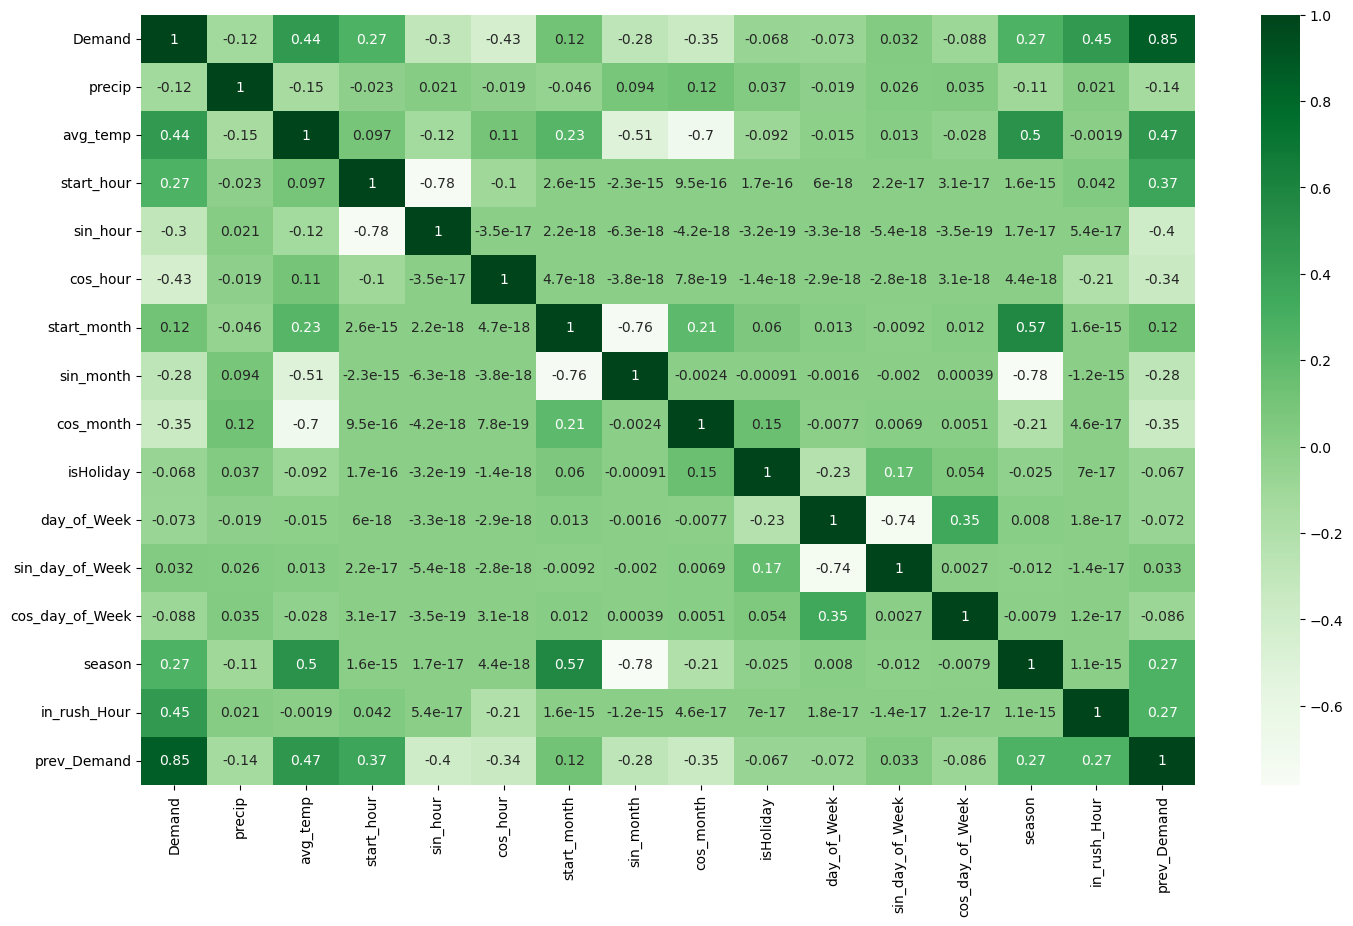

In [24]:
#visualize correlation between features

plt.figure(figsize=(17,10))
sns.heatmap(df_load_weather.corr(), cmap = 'Greens', annot = True)
plt.show()

In [25]:
# Since prev_Demand and prev_Demand2 seem to be highly correlated, we dropped prev_Demand2 as a feature
# Doing this, protects our model from considering unnecessary/redundant features and prevent the performance
# from being harmed



In [26]:
# the correlation matrix paints the same picture, as our feature selecting lasso regression earlier

In [27]:
# Regression
# We already have quite the clear picture on how important our features are, based on our Lasso Regression earlier

In [112]:
features = ['cos_hour','sin_month','avg_temp', 'in_rush_Hour', 'prev_Demand']
features.append('Demand')
features.append(features.pop(features.index('Demand')))
df1 = df_load_weather[features]

    # split the data with 70% training data
train, test = train_test_split(df1, test_size = 0.3, random_state = 42)
X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]

X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]

    

In [116]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)

      cos_hour     sin_month  avg_temp  in_rush_Hour  prev_Demand
1444  0.500000  1.000000e+00     2.800             0          7.0
1652  0.500000  1.000000e+00     5.000             0        131.0
7496 -0.500000 -5.000000e-01     2.100             1        421.0
1893  0.707107  1.000000e+00     1.700             0        180.0
3880 -0.500000  1.224647e-16    17.900             1        770.0
...        ...           ...       ...           ...          ...
5734  0.866025 -8.660254e-01    33.900             0        441.0
5191 -0.258819 -8.660254e-01    26.100             1         95.0
5390 -0.866025 -8.660254e-01    24.575             0        770.0
860   0.500000  8.660254e-01   -11.700             0         56.0
7270  0.866025 -8.660254e-01    17.800             0        253.0

[6132 rows x 5 columns]


/Users/vincent/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/Users/vincent/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline i

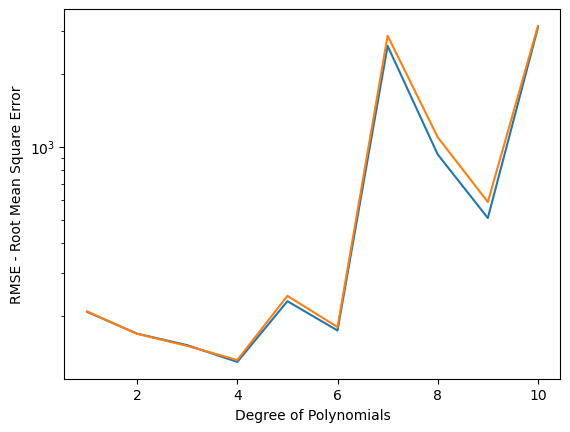

In [134]:
#Eigener Code
training_error = []
testing_error = []
print(X_train)
y_train.fillna(0, inplace=True)
y_test.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

for degree_poly in range (1, 11):
    
    #print("current polynomial: ", degree_poly)
    poly = PolynomialFeatures(degree = degree_poly)
    X_train_poly = poly.fit_transform(X_train) 
    X_test_poly = poly.fit_transform(X_test)
    #print(X_train_poly)
 

    linear_reg = LinearRegression(fit_intercept = False, normalize = True)
    linear_reg.fit(X_train_poly, y_train)
    y_train_pred = linear_reg.predict(X_train_poly)
    y_test_pred = linear_reg.predict(X_test_poly)
    
    #print('R^2 for polynomial degree ', degree_poly, ' is: ', r2_score(y_train,prediction))
    training_error.append((math.sqrt(mean_squared_error(y_train, y_train_pred))))
    testing_error.append((math.sqrt(mean_squared_error(y_test, y_test_pred))))

plt.semilogy(range(1,11), training_error, range(1,11), testing_error)
plt.xlabel('Degree of Polynomials')
plt.ylabel('RMSE - Root Mean Square Error')
plt.show()


current lambda:  1e-10
current lambda:  4.893900918477499e-10
current lambda:  2.395026619987491e-09
current lambda:  1.1721022975334793e-08
current lambda:  5.736152510448681e-08
current lambda:  2.807216203941181e-07
current lambda:  1.3738237958832638e-06
current lambda:  6.723357536499335e-06
current lambda:  3.290344562312671e-05
current lambda:  0.00016102620275609426
current lambda:  0.0007880462815669921
current lambda:  0.0038566204211634724
current lambda:  0.018873918221350997
current lambda:  0.09236708571873885
current lambda:  0.45203536563602403
current lambda:  2.21221629107045
current lambda:  10.826367338740562
current lambda:  52.983169062837234
current lambda:  259.2943797404678
current lambda:  1268.9610031679233
current lambda:  6210.169418915629
current lambda:  30391.953823132073
current lambda:  148735.21072935118
current lambda:  727895.3843983161
current lambda:  3562247.8902624515
current lambda:  17433288.221999943
current lambda:  85316785.24172848
current

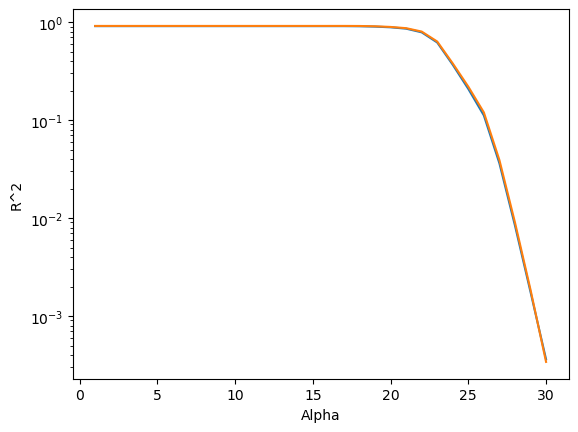

In [158]:
#Eigener Code
lamd_range = np.logspace(-10,10,30)
X_test.fillna(0, inplace=True)
poly_ridge = PolynomialFeatures(degree = 4)

training_error_ridge = []
test_error_ridge = []

for lambd in lamd_range:
    
    X_train_poly_ridge = poly_ridge.fit_transform(X_train_scaled) 
    X_test_poly_ridge = poly_ridge.fit_transform(X_test_scaled)
    print("current lambda: ", lambd)

    model_ridge = Ridge(alpha = lambd, solver = 'lsqr')
    model_ridge.fit(X_train_poly_ridge, y_train)
    y_pred_ridge = model_ridge.predict(X_train_poly_ridge)
    
    y_pred_test_ridge = model_ridge.predict(X_test_poly_ridge)

   # print((mean_squared_error(y_train, y_pred_ridge)))
    training_error_ridge.append(r2_score(y_train, y_pred_ridge))
    test_error_ridge.append((r2_score(y_test, y_pred_test_ridge)))

print(training_error_ridge)
plt.semilogy(range(1,31), training_error_ridge, range(1,31), test_error_ridge)
plt.xlabel('Alpha')
plt.ylabel('R^2')
plt.show()

## Decision Tree

In [ ]:
demand = y_train.values
average_temperature = X_train['avg_temp'].values

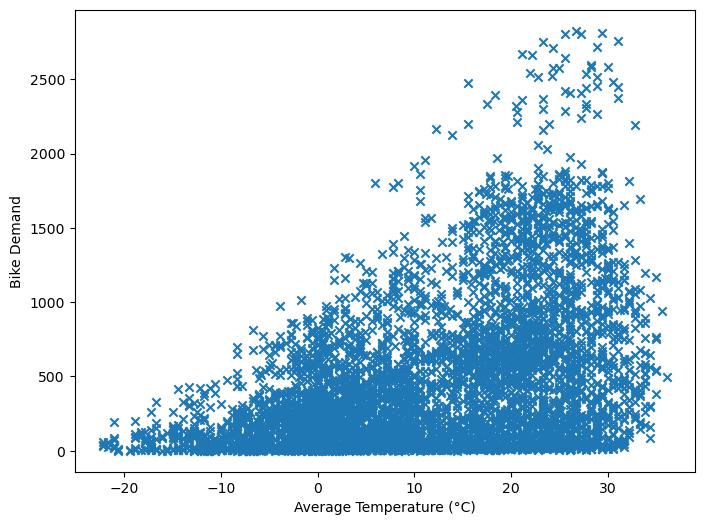

In [32]:
plt.figure(figsize = (8,6))
plt.scatter(average_temperature, demand, marker="x")
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Bike Demand")
plt.show()

In [37]:
def plot_tree_regression_line(tree_depth, dependent_variable, regressor):

    Tree_reg = DecisionTreeRegressor(max_depth=tree_depth,
                                    criterion="squared_error") # Other options: "friedman_mse", "mae"
    Tree_reg.fit(regressor.reshape((-1,1)), dependent_variable)
    Y_pred = Tree_reg.predict(regressor.reshape((-1,1)))
    
    attributes = Tree_reg.tree_

    # plot
    plt.figure(figsize = (8,6))
    plt.scatter(regressor, dependent_variable, marker="x")
    plt.plot(np.arange(-18,40,1), Tree_reg.predict(np.arange(-18,40,1).reshape((-1,1))), marker="x", color='C1')
    
    print("number of nodes: ", attributes.node_count)
    print("number of leafs: ", attributes.n_leaves)
    print("R^2: ", r2_score(dependent_variable, Y_pred))
    

number of nodes:  269
number of leafs:  135
R^2:  0.23670963090766572


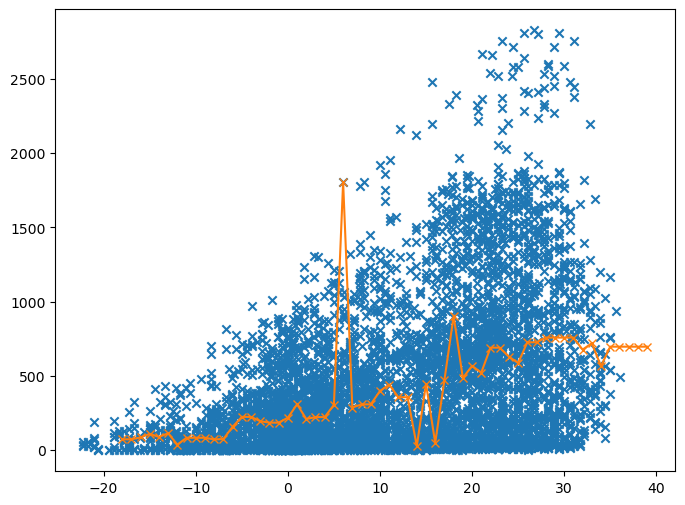

In [38]:
plot_tree_regression_line(8, demand, average_temperature)

In [39]:
previous_demand = X_train['prev_Demand'].values

number of nodes:  397
number of leafs:  199
R^2:  0.7776233979394647


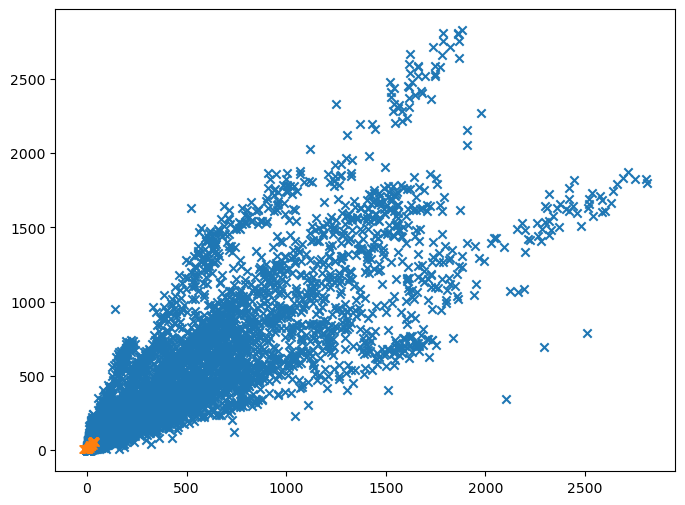

In [40]:
plot_tree_regression_line(8, demand, previous_demand)

In [41]:
def plot_regression_tree_sklearn(tree_depth, dependent_variable, regressor):

    # Fit regression model (to full data)
    model = DecisionTreeRegressor(max_depth=tree_depth)
    model.fit(regressor.reshape((-1,1)), dependent_variable) 
    
    dot_data = export_graphviz(model,
                              feature_names=["High_temp"])  
    
    graph = graphviz.Source(dot_data) 
    
    return graph


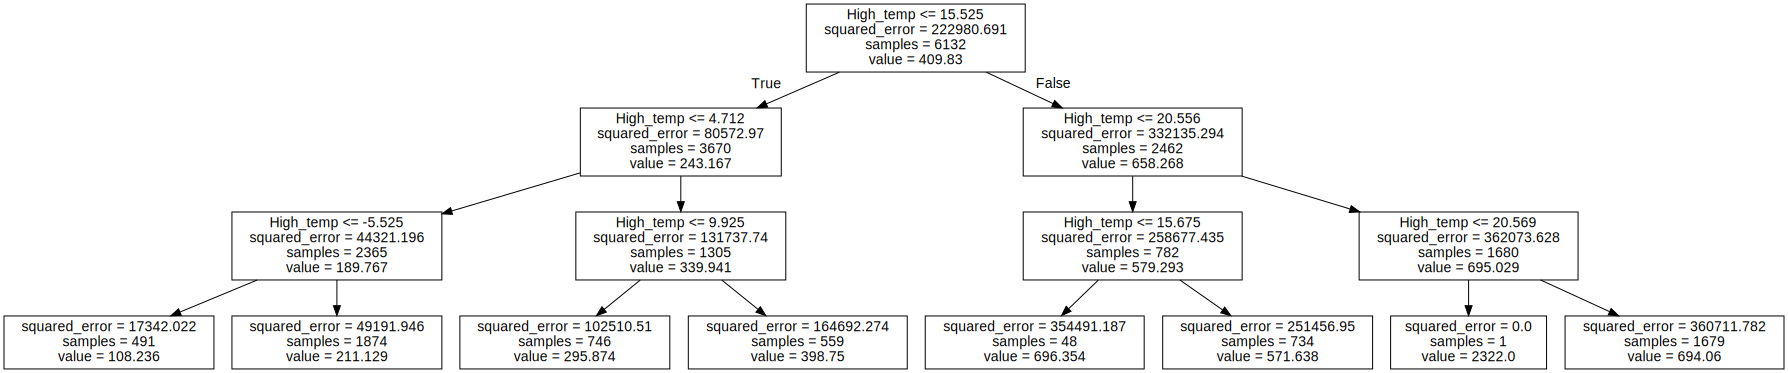

In [42]:
plot_regression_tree_sklearn(3, demand, average_temperature)

#### Fit on whole dataset

In [43]:
tree_depth = 8
# Fit regression model (to full data)
Tree_reg = DecisionTreeRegressor(
    max_depth=tree_depth,criterion="squared_error"
)
Tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8)

#### Performance on training data

In [44]:
y_pred_train = Tree_reg.predict(X_train)

mse = mean_squared_error(y_train,y_pred_train)
print("Mean squared error: ", mse)
r2 = r2_score(y_train, y_pred_train)
print("R squared: ", r2)

Mean squared error:  6200.823622762294
R squared:  0.9721912081029043


#### NaN in test set

In [45]:
X.isna().any()

precip             False
avg_temp           False
start_hour         False
sin_hour           False
cos_hour           False
start_month        False
sin_month          False
cos_month          False
isHoliday          False
day_of_Week        False
sin_day_of_Week    False
cos_day_of_Week    False
season             False
in_rush_Hour       False
prev_Demand         True
dtype: bool

In [46]:
X_clean = X.iloc[1:]
y_clean = y.iloc[1:]
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size = 0.3, random_state = 42)

#### Performance on test data

In [47]:
y_pred_test = Tree_reg.predict(X_test)

mse = mean_squared_error(y_test,y_pred_test)
print("Mean squared error: ", mse)
r2 = r2_score(y_test, y_pred_test)
print("R squared: ", r2)

Mean squared error:  8172.43038105756
R squared:  0.9638284235210453


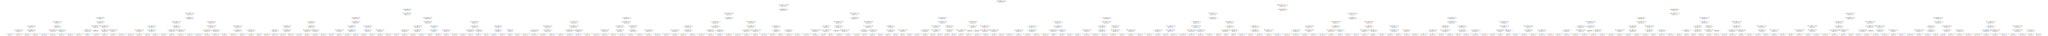

In [48]:
dot_data = export_graphviz(
    Tree_reg,
    feature_names=X.columns
)
graph = graphviz.Source(dot_data) 
graph

#### Hyperparameter tuning

In [56]:
def fit_decision_tree(tree_depth):
    Tree_reg = DecisionTreeRegressor(
        max_depth=tree_depth,criterion="squared_error"
    )
    Tree_reg.fit(X_train, y_train)
    return Tree_reg

In [75]:
def evaluate_decision_tree_train(tree_depth):
    reg = fit_decision_tree(tree_depth)
    
    y_pred_train = reg.predict(X_train)
    
    return mean_squared_error(y_train,y_pred_train)

def evaluate_decision_tree_test(tree_depth):
    reg = fit_decision_tree(tree_depth)
    
    y_pred_test = reg.predict(X_test)
    
    return mean_squared_error(y_test,y_pred_test)

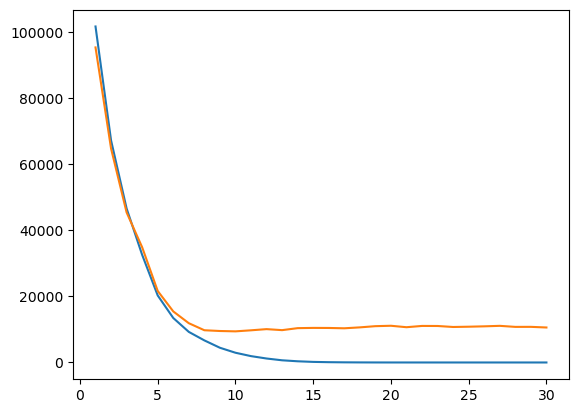

In [76]:
x = np.linspace(1, 30, 30, dtype = int)
plt.plot(x, list(map(evaluate_decision_tree_train, x)))
plt.plot(x, list(map(evaluate_decision_tree_test, x)))
plt.show()

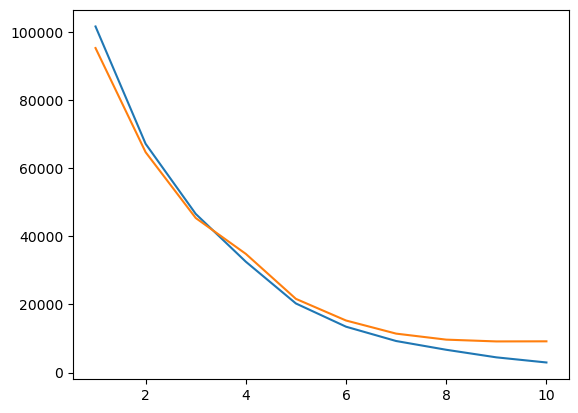

In [77]:
x = np.linspace(1, 10, 10, dtype = int)
plt.plot(x, list(map(evaluate_decision_tree_train, x)))
plt.plot(x, list(map(evaluate_decision_tree_test, x)))
plt.show()

## Random Forest

In [49]:
RandomForest_reg = RandomForestRegressor(max_depth=10, random_state=0)
RandomForest_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=0)

#### Performance on training data

In [50]:
y_pred_train = RandomForest_reg.predict(X_train)

mse = mean_squared_error(y_train,y_pred_train)
print("Mean squared error: ", mse)
r2 = r2_score(y_train, y_pred_train)
print("R squared: ", r2)

Mean squared error:  2191.5827496236298
R squared:  0.9905237206076484


#### Performance on test data

In [51]:
y_pred_test = RandomForest_reg.predict(X_test)

mse = mean_squared_error(y_test,y_pred_test)
print("Mean squared error: ", mse)
r2 = r2_score(y_test, y_pred_test)
print("R squared: ", r2)

Mean squared error:  5953.950223582947
R squared:  0.9736475251764273


#### Hyperparameter tuning

In [80]:
def fit_forest(max_depth):
    reg = RandomForestRegressor(
        max_depth=max_depth, 
        random_state=0
    )
    reg.fit(X_train, y_train)
    return reg

In [81]:
def evaluate_forest_train(max_depth):
    reg = fit_forest(max_depth)
    
    y_pred_train = reg.predict(X_train)
    
    return mean_squared_error(y_train,y_pred_train)

def evaluate_forest_test(max_depth):
    reg = fit_forest(max_depth)
    
    y_pred_test = reg.predict(X_test)
    
    return mean_squared_error(y_test,y_pred_test)

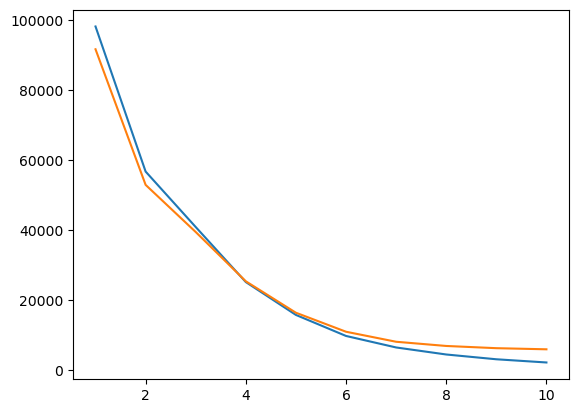

In [84]:
x = np.linspace(1, 10, 10, dtype = int)
plt.plot(x, list(map(evaluate_forest_train, x)))
plt.plot(x, list(map(evaluate_forest_test, x)))
plt.show()

## K-Nearest Neighbors

In [52]:
KNeighbor_reg = KNeighborsClassifier(n_neighbors=2)
KNeighbor_reg.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

#### Performance on training data

In [94]:
y_pred_train = KNeighbor_reg.predict(X_train)

mse = mean_squared_error(y_train,y_pred_train)
print("Mean squared error: ", mse)
r2 = r2_score(y_train, y_pred_train)
print("R squared: ", r2)

Mean squared error:  32853.30712771163
R squared:  0.8579441650750365


#### Performance on test data

In [93]:
y_pred_test = KNeighbor_reg.predict(X_test)

mse = mean_squared_error(y_test,y_pred_test)
print("Mean squared error: ", mse)
r2 = r2_score(y_test, y_pred_test)
print("R squared: ", r2)

Mean squared error:  66031.75152207002
R squared:  0.7077402389678348


#### Hyperparameter tuning

In [86]:
def fit_neighbors(n_neighbors):
    reg = KNeighborsClassifier(n_neighbors=n_neighbors)
    reg.fit(X_train, y_train)
    return reg

In [87]:
def evaluate_neighbors_train(n_neighbors):
    reg = fit_neighbors(n_neighbors)
    
    y_pred_train = reg.predict(X_train)
    
    return mean_squared_error(y_train,y_pred_train)

def evaluate_neighbors_test(n_neighbors):
    reg = fit_neighbors(n_neighbors)
    
    y_pred_test = reg.predict(X_test)
    
    return mean_squared_error(y_test,y_pred_test)

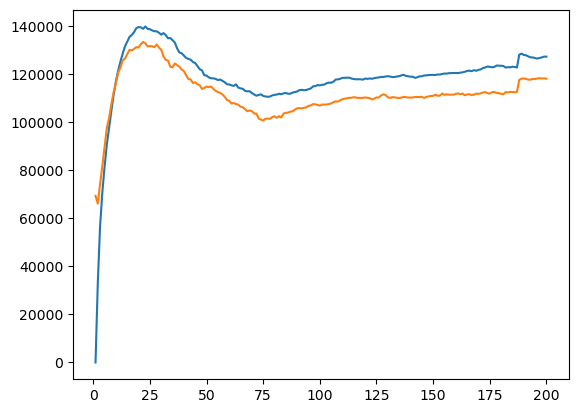

In [97]:
x = np.linspace(1, 200, 200, dtype = int)
plt.plot(x, list(map(evaluate_neighbors_train, x)))
plt.plot(x, list(map(evaluate_neighbors_test, x)))
plt.show()